# Experiments with the joining validator

In this notebook we experiment with different configurations of the joining validator. In the previous experiments we have been using the default configuration of the joining validator, namely a RandomForestClassifier with 100 trees and standard (adaptive) model parameters. In this notebook we will experiment with different configurations of the joining validator strategy, namely:

- Different classifiers: we will experiment with different classifiers, such as KNN, SVM, and MLP.
- One class classification and Outlier Detection models: Using different kinds of validator models from the basic classification scheme may have an effect?
- Different thresholds: we will experiment with different thresholds to see if privacy/utility trade-offs can be controlled.

Alltogether we hope to begin to answer the question; Wheather or not a better or worse performance of the joining validator is desired, what configurations should be used?

For the low level results, we will continue using the Hepatitis dataset split into categorical and numerical partitions, but for the high level results we will also explore other datasets. We will focus on the synthpop-ADSGAN DGM, because it has more room for improvement than the DataSynthesizer-DPGAN DGM.

## High level results

First, we will show the big experiment also presented in the paper. The figure shows all the datasets used in the study, with categorical and numerical partitions distributed to synthpop and ADSGAN respectively, and using different joining validators. The noteworthy results are highlighted in the figure.

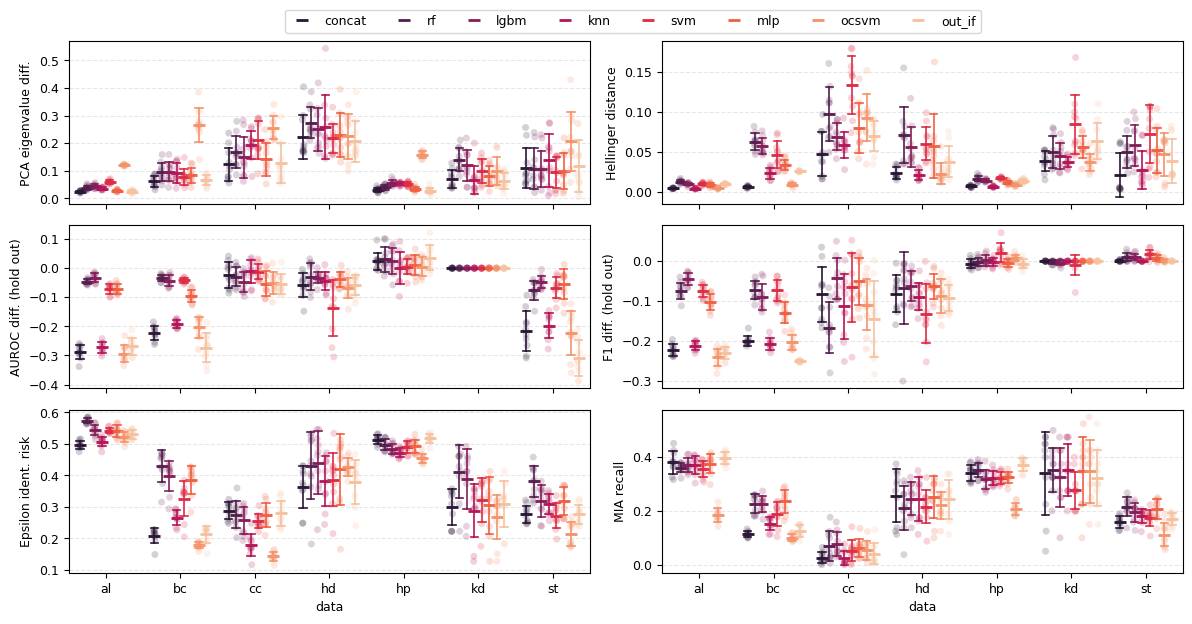

In [46]:
import pandas as pd

from typing import Dict, List

import seaborn as sns
import matplotlib.pyplot as plt

rcp = {'font.size': 9, 'font.family': 'sans', "mathtext.fontset": "dejavuserif"}
plt.rcParams.update(**rcp)

def make_validator_pointplot(datapath: str, metrics: Dict[str,str]) -> None:
    """ Function to plot a pointplot with mean results of the different validators for each metric."""

    df = pd.read_csv(datapath)

    validators = df['validator'].unique()
    df = df[['data', 'validator'] + list(metrics.keys())]

    # Create the pointplot
    fig, axes = plt.subplots(len(metrics)//2, 2, figsize=(12, len(metrics)), sharex=True)

    colors = sns.color_palette("rocket", n_colors=len(validators))    

    axes = axes.flatten()
    for i, metric in enumerate(metrics.keys()):
        sns.stripplot(
            data=df, x="data", y=metric, hue="validator",
            alpha=0.2, legend=False, palette=colors, dodge=True, ax=axes[i]
        )
        sns.pointplot(
            data=df, x="data", y=metric, hue="validator",
            linestyle="none", dodge=.8 - .8 / len(validators), err_kws={'linewidth':1.2}, capsize=0.1, errorbar='sd',
            palette=colors, markersize = 8, markers="_", ax=axes[i]
        )
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)
        axes[i].set_ylabel(metrics[metric])

        axes[i].get_legend().remove()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=8, fontsize=9, bbox_to_anchor=(0.53, 1.04), bbox_transform=fig.transFigure)

    plt.tight_layout()
    plt.savefig("experiments/figures/figure5_validator_pointplot.pdf", bbox_inches='tight')
    plt.show()
    pass

metrics = {
    "pca_eigval_diff" : "PCA eigenvalue diff.",
    "avg_h_dist": "Hellinger distance",
    "auroc": "AUROC diff. (hold out)",
    "cls_F1_diff_hout": "F1 diff. (hold out)",
    "eps_identif_risk": "Epsilon ident. risk",
    "mia_recall": "MIA recall",
}

make_validator_pointplot("experiments/results/validator_case_study/full_validator_results.csv", metrics)

Based on this plot there seems to be no clear better choice than the random forest model with its default configuration, some models do better or worse on certain datasets, the differentially private random forest model, the one class svm, and outlier models stand out a bit doing generally better on privacy but worse on utility. More than any one classifier being a profoundly better choice, the results hint at the strictness/lenience of the joining validator impacting the trade-off between privacy and utility

This needs to be further investigated.

## Fixed threshold experiments

In the next series of experiments we use a the same validator models but affix the threshold at different positions. We will use the Hepatitis dataset for this experiment.

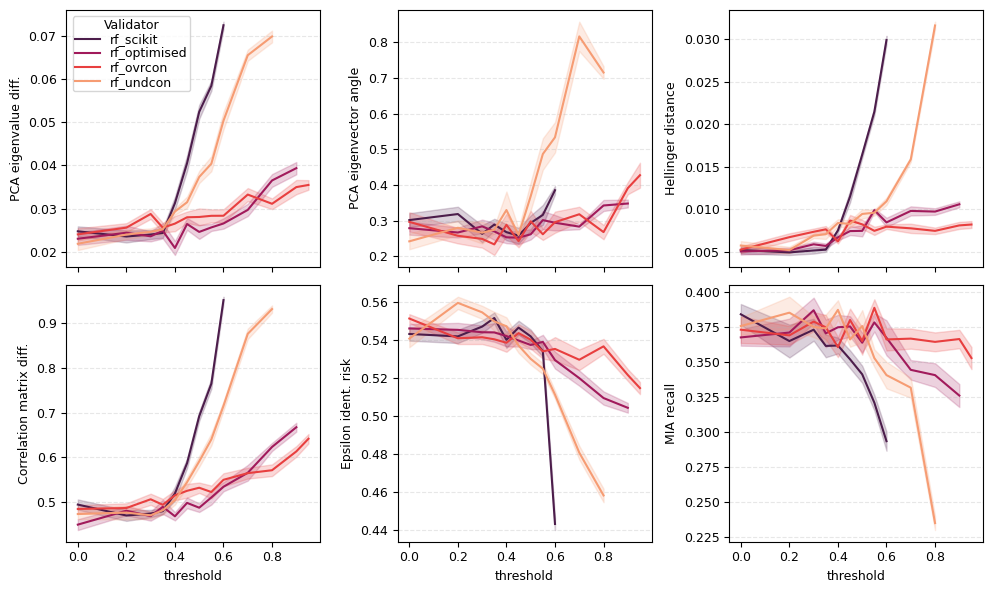

In [86]:
import numpy as np
import pandas as pd

from typing import Dict, List

import seaborn as sns
import matplotlib.pyplot as plt

rcp = {'font.size': 9, 'font.family': 'sans', "mathtext.fontset": "dejavuserif"}
plt.rcParams.update(**rcp)

def make_threshold_continuum_plot(datapath: str, series: str, dataset: str, valid_models: List[str], metrics: Dict[str,str]) -> None:
    """ This plot shows how the performance of different metrics vary 
    with using different validators at different threshold. """

    df = pd.read_csv(datapath)
    df = df[df['experiment'] == series]

    df = df[df['validator'].isin(valid_models)]
    df = df[df['data'] == dataset]
    df = df[['validator', 'threshold'] + list(metrics.keys())]

    # Create the pointplot
    fig, axes = plt.subplots(int(np.ceil(len(metrics)/3)), 3, figsize=(10, 3*int((np.ceil(len(metrics)/3)))), sharex=True)

    colors = sns.color_palette("rocket", n_colors=len(valid_models))

    axes = axes.flatten()
    for i, metric in enumerate(metrics.keys()):
        sns.lineplot(
            data=df, x="threshold", y=metric, hue="validator",
            palette=colors, ax=axes[i], errorbar='se'
        )
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)
        axes[i].set_ylabel(metrics[metric])

        if i == 0:
            axes[i].legend(title="Validator", ncols=1, borderpad=0.2, labelspacing=0.1, columnspacing=0.5)
        else:
            axes[i].get_legend().remove()
    
    plt.tight_layout()
    plt.savefig("experiments/figures/figure7a_threshold_continuum_plot.pdf", bbox_inches='tight')
    # plt.show()
    pass

metrics = {
    "pca_eigval_diff" : "PCA eigenvalue diff.",
    "pca_eigvec_ang" : "PCA eigenvector angle",
    "avg_h_dist": "Hellinger distance",
    "corr_mat_diff": "Correlation matrix diff.",
    # "auroc": "AUROC diff. (hold out)",
    # "avg_F1_diff": "F1 diff. (training)",
    # "avg_F1_diff_hout": "F1 diff. (hold out)",
    "eps_identif_risk": "Epsilon ident. risk",
    "mia_recall": "MIA recall",
}

SERIES = "sp_ad"

make_threshold_continuum_plot("experiments/results/validator_case_study/full_threshold_results.csv", SERIES, "hp", ["rf_scikit", "rf_optimised", "rf_ovrcon", "rf_undcon"], metrics)

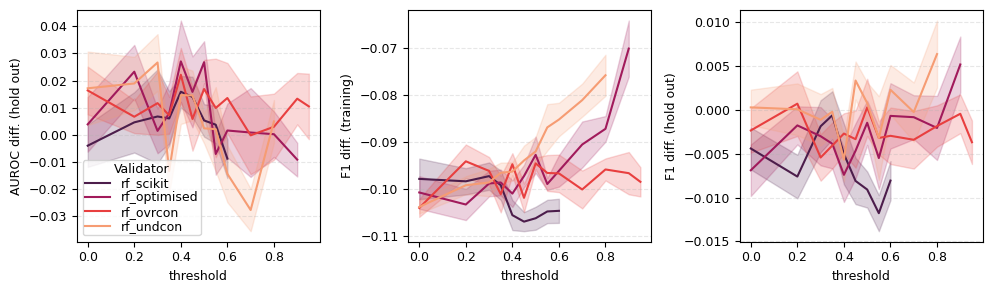

In [85]:

metrics = {
    "auroc": "AUROC diff. (hold out)",
    "avg_F1_diff": "F1 diff. (training)",
    "avg_F1_diff_hout": "F1 diff. (hold out)",
}

SERIES = "sp_ad"

make_threshold_continuum_plot("experiments/results/validator_case_study/full_threshold_results.csv", SERIES, "hp", ["rf_scikit", "rf_optimised", "rf_ovrcon", "rf_undcon"], metrics)

In [83]:
# retrieve metrics for experiment series at thresholds
def extract_results(datapath: str, series: str, dataset: str, valid_model: str, threshold: float) -> None:

    df = pd.read_csv(datapath)
    df = df[df['experiment'] == series]

    df = df[df['validator'] == valid_model]
    df = df[df['data'] == dataset]
    
    if threshold is not None:
        df = df[df['threshold'] == threshold]

        df = df.drop(columns=['rep_idx', 'experiment', 'data', 'validator', 'threshold'])
    else:
        df = df.drop(columns=['rep_idx', 'experiment', 'data', 'validator', 'time'])
    mean_values = df.mean()
    sem_error = df.sem()

    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])
    
    print(f"Results for validator {valid_model} at threshold {threshold}:")
    print(results)
    pass

extract_results("experiments/results/validator_case_study/full_validator_results.csv", SERIES, "hp", "concat", None)
extract_results("experiments/results/validator_case_study/full_threshold_results.csv", SERIES, "hp", "rf_scikit", 0.55)
extract_results("experiments/results/validator_case_study/full_threshold_results.csv", SERIES, "hp", "rf_optimised", 0.9)
extract_results("experiments/results/validator_case_study/full_threshold_results.csv", SERIES, "hp", "rf_ovrcon", 0.95)
extract_results("experiments/results/validator_case_study/full_threshold_results.csv", SERIES, "hp", "rf_undcon", 0.8)

Results for validator concat at threshold None:
                      mean       sem
pca_eigval_diff   0.030648  0.002408
pca_eigvec_ang    0.511660  0.063470
avg_h_dist        0.006739  0.000365
corr_mat_diff     0.496084  0.017369
auroc             0.023287  0.009267
cls_F1_diff      -0.077961  0.001891
cls_F1_diff_hout -0.005964  0.003588
eps_identif_risk  0.513394  0.004210
priv_loss_eps     0.310769  0.003873
mia_recall        0.342899  0.009348
mia_precision     0.505974  0.009459
Results for validator rf_scikit at threshold 0.55:
                      mean       sem
pca_eigval_diff   0.058449  0.001168
pca_eigvec_ang    0.316349  0.028106
avg_h_dist        0.021463  0.000415
corr_mat_diff     0.764604  0.011343
auroc             0.003692  0.006963
avg_F1_diff      -0.104771  0.002482
avg_F1_diff_hout -0.011777  0.002056
eps_identif_risk  0.534027  0.003015
priv_loss_eps     0.338552  0.003101
median_DCR        0.899089  0.002068
mia_recall        0.321159  0.005580
mia_precision

## Sample diversity and threshold experiments

We postulate that the reason for the apparent increased privacy of the synthetic data with increasing threshold is due to the decrease in sample diversity.


In [1]:
### Imports
import pandas as pd

### Load data
df_train = pd.read_csv('experiments/datasets/hepatitis_train.csv')
df_test = pd.read_csv('experiments/datasets/hepatitis_test.csv')

label = 'b_class'

cat_atts = df_train.select_dtypes(include='object').columns.tolist()

for att in [att for att in df_train.columns if att not in cat_atts]:
    if len(df_train[att].unique()) <= 5:
        cat_atts.append(att)

num_atts = [att for att in df_train.columns if att not in cat_atts]



In [ ]:
from sklearn.ensemble import RandomForestClassifier

from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_validator import JoiningValidator
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator

JV = JoiningValidator(classifier_model_base=RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=5), verbose=True, calibration_method='sigmoid')
JS = UsingJoiningValidator(join_validator_model=JV, threshold_decay=0, patience=25, max_iter=500)
dgms = DisjointGenerativeModels(df_train, {'synthpop': cat_atts, 'adsgan': num_atts}, joining_strategy=JS, worker_id=0)
dgms.join_multiplier = 24

df_subopt_auto = dgms.fit_generate()
print(df_subopt_auto.shape)

In [ ]:
from experiments.auxiliaries.plotting import histograms_of_attributes

histograms_of_attributes(df_train, df_subopt_auto, num_atts)

In [8]:
dgms._strategy.join_validator.threshold = 0.65

df_subopt_lowered = dgms.conduct_joining()
df_subopt_lowered = dgms.dm.postprocess(df_subopt_lowered)

Predicted good joins fraction: 0.1076923076923077


In [ ]:
histograms_of_attributes(df_train, df_subopt_lowered, num_atts)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_validator import JoiningValidator
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator

JV = JoiningValidator(classifier_model_base=RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=5), verbose=True, calibration_method='sigmoid')
JS = UsingJoiningValidator(join_validator_model=JV, threshold_decay=0, patience=25, max_iter=500)
dgms = DisjointGenerativeModels(df_train, {'synthpop': cat_atts, 'dpgan': num_atts}, joining_strategy=JS, worker_id=0)
dgms.join_multiplier = 8

df_optimal = dgms.fit_generate()

In [ ]:
from experiments.auxiliaries.plotting import histograms_of_attributes
histograms_of_attributes(df_train, df_optimal, num_atts)

In [ ]:
from disjoint_generative_model.utils.generative_model_adapters import generate_synthetic_data

df_dpgan = generate_synthetic_data(df_train, 'dpgan')

histograms_of_attributes(df_train, df_dpgan, num_atts)

In [14]:
### case study table
def case_study_table(normalised: bool = False) -> None:
    for att in cat_atts:
        if att != label:
            print(f"\nAttribute: {att}")

            real = df_train.groupby(label)[att].value_counts(normalize=normalised).unstack().T
            syn_l = df_subopt_lowered.groupby(label)[att].value_counts(normalize=normalised).unstack().T
            syn_t = df_subopt_auto.groupby(label)[att].value_counts(normalize=normalised).unstack().T

            res = pd.concat([real, syn_l, syn_t], axis=1)
            print(res)
    pass

case_study_table(normalised=False)


Attribute: WBC
b_class           0    1    0    1    0    1
WBC                                         
(0, 4000]        32   96   23   85   29   98
(11000, 12101]   33   97   38   99   36   99
(4000, 11000]   202  645  208  652  195  648

Attribute: RBC
b_class               0    1    0    1    0    1
RBC                                             
(3000000, 5000000]  259  822  251  820  242  816
(5000000, 5018451]    8   16   18   16   18   29

Attribute: Plat
b_class             0    1    0    1    0    1
Plat                                          
(100000, 200000]  198  641  198  623  159  559
(200000, 226465]   52  155   42  160   55  183
(93013, 100000]    17   42   29   53   46  103

Attribute: RNA Base
b_class         0    1    0    1    0    1
RNA Base                                  
(5, 1201086]  267  838  269  836  260  845

Attribute: RNA 4
b_class           0      1      0      1      0      1
RNA 4                                                 
(0, 5]          N

### Calibrate Model to Hepatitis

In this part we show the few lines of code we use to calibrate the different models to the Hepatitis dataset.

In [6]:
### Imports
import pickle

import numpy as np
import pandas as pd

from pandas import DataFrame
from typing import Literal, List, Dict

from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_validator import JoiningValidator
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator

### Load data
df_train = pd.read_csv('experiments/datasets/hepatitis_train.csv')
df_test = pd.read_csv('experiments/datasets/hepatitis_test.csv')

label = 'b_class'

cat_atts = df_train.select_dtypes(include='object').columns.tolist()

for att in [att for att in df_train.columns if att not in cat_atts]:
    if len(df_train[att].unique()) <= 5:
        cat_atts.append(att)

num_atts = [att for att in df_train.columns if att not in cat_atts]

In [7]:
models = ['synthpop', 'adsgan']

def hyper_params_search(validator_model: object, parameter_grid: dict, calibration_method: Literal['sigmoid', 'isotonic'] | None) -> None:

    JV = JoiningValidator(validator_model, model_parameter_grid = parameter_grid, calibration_method=calibration_method, verbose=True)
    JS = UsingJoiningValidator(JV)
    dgms = DisjointGenerativeModels(df_train, {models[0]: cat_atts, models[1]: num_atts}, joining_strategy=JS)
    dgms.num_samples = 20 # required or it will throw an error
    dgms._setup()
    
    dgms._make_calibration_plot(df_test, save=False, stats=False)
    # dgms._make_pred_pointplot(df_test, save=False)
    return dgms

Validator: Grid search for hyperparameters
Validator: Best Brier score -0.239934 using {'quadraticdiscriminantanalysis__reg_param': 0.1, 'quadraticdiscriminantanalysis__tol': 0.001}
Validator: Calibration improved the model from 0.3325 to 0.3287


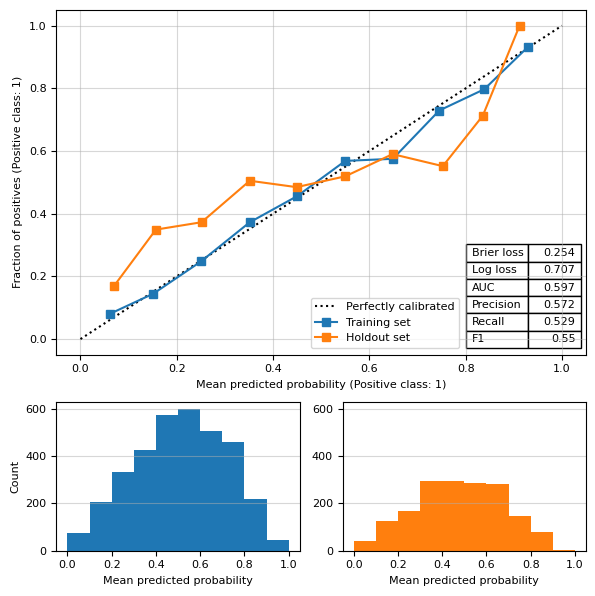

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
parameter_grid = {'quadraticdiscriminantanalysis__reg_param': [0.01, 0.1, 0.5, 1.0], 
                  'quadraticdiscriminantanalysis__tol': np.power(10, np.arange(-3, 1, dtype=float))}

clf = make_pipeline(RobustScaler(), QuadraticDiscriminantAnalysis(reg_param =0.1, tol= 0.001))

hyper_params_search(clf, parameter_grid, 'sigmoid')
# Best found parameters: reg_param=0.1, tol=1e-05

Validator: No search parameters specified. Using default configuration.
Validator: Calibration did not improve the model. Using the original model.


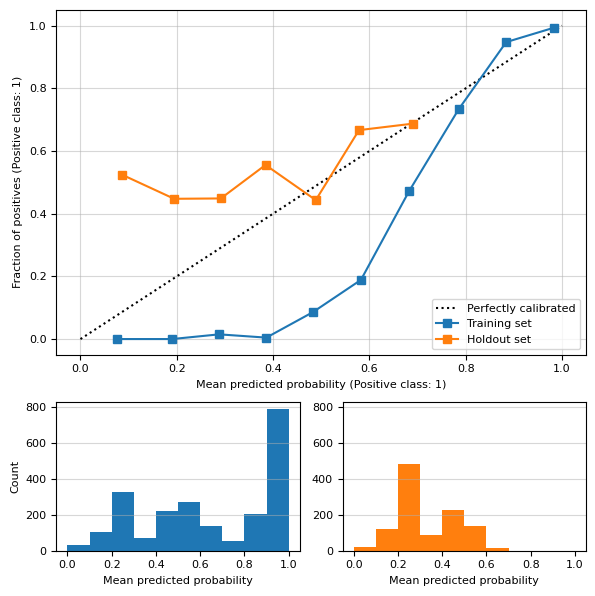

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameter_grid = {'n_estimators': [5, 10, 50], 'max_depth': [5, 10, 20], 'criterion': ['entropy', 'log_loss']}

dgms = hyper_params_search(RandomForestClassifier(), parameter_grid, 'sigmoid')
# Best found parameters: criterion='log_loss', max_depth=20, n_estimators=10

# with open('experiments/validator_models/hp_rf_optimised.obj', 'wb') as file:
#     pickle.dump(dgms._strategy.join_validator, file)

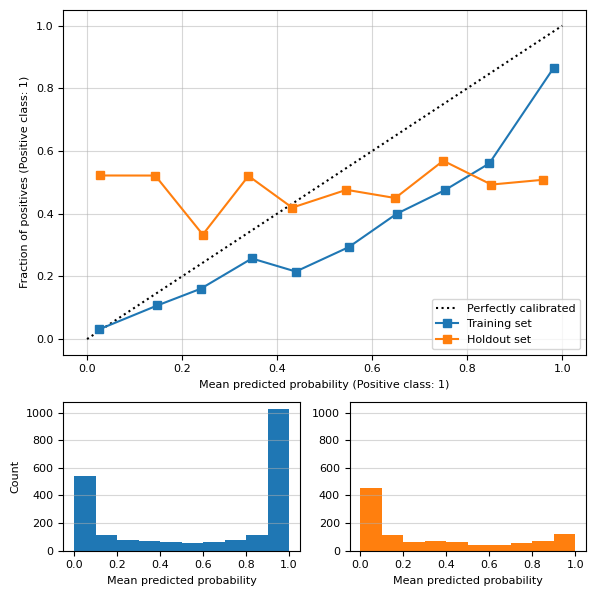

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameter_grid = {'n_estimators': [3, 5, 6], 'max_depth': [3, 5, 10, 13], 'criterion': ['gini']}

dgms = hyper_params_search(RandomForestClassifier(), parameter_grid, "sigmoid")
# Best found parameters: criterion='gini', max_depth=5, n_estimators=5

# with open('experiments/validator_models/hp_rf_ovrcon.obj', 'wb') as file:
#     pickle.dump(dgms._strategy.join_validator, file)

Validator: Grid search for hyperparameters
Validator: Best Brier score 0.533710 using {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 6}
Validator: Calibration improved the model from 0.3674 to 0.3649


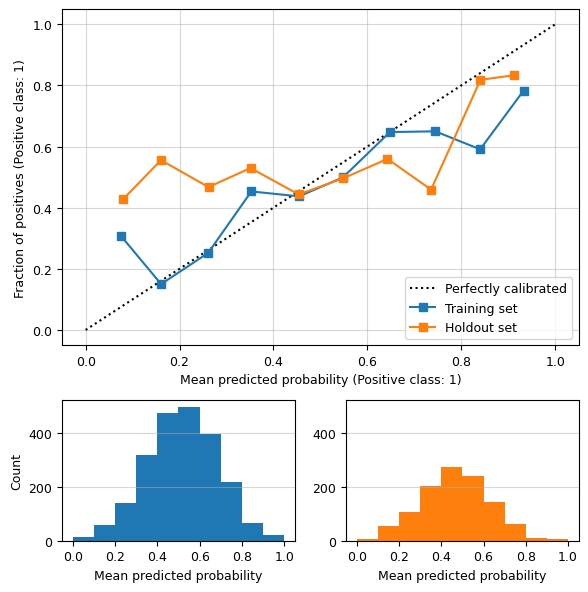

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameter_grid = {'n_estimators': [3, 5, 6], 'max_depth': [3, 5], 'criterion': ['gini']}

dgms = hyper_params_search(RandomForestClassifier(), parameter_grid, "sigmoid")
# Best found parameters: criterion='gini', max_depth=5, n_estimators=5

# with open('experiments/validator_models/hp_rf_undcon.obj', 'wb') as file:
#     pickle.dump(dgms._strategy.join_validator, file)

Validator: Grid search for hyperparameters
Validator: Best Brier score -0.233897 using {'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'binary'}
Validator: Calibration improved the model from 0.0559 to 0.0545


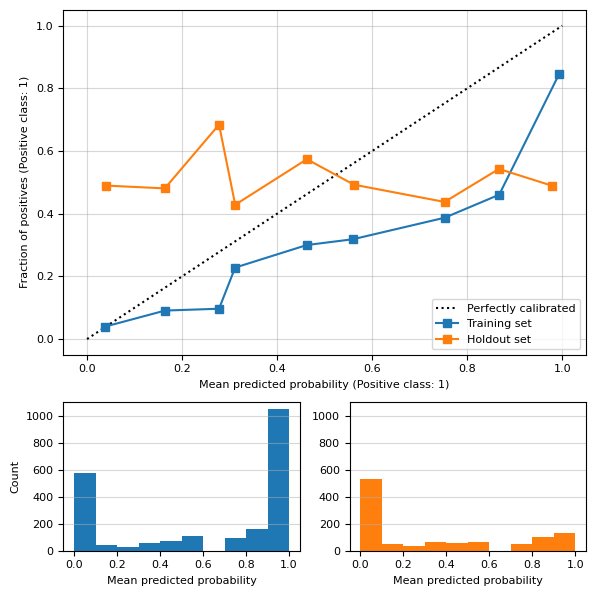

In [5]:
from lightgbm import LGBMClassifier
parameter_grid = {'n_estimators': [25, 50, 100], 'learning_rate': np.power(10, np.arange(-3, 1, dtype=float)), 'objective': ['binary', 'cross_entropy']}

hyper_params_search(LGBMClassifier(), parameter_grid, 'isotonic')

Validator: Grid search for hyperparameters
Validator: Best Brier score -0.240726 using {'algorithm': 'kd_tree', 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
Validator: Calibration did not improve the model. Using the original model.


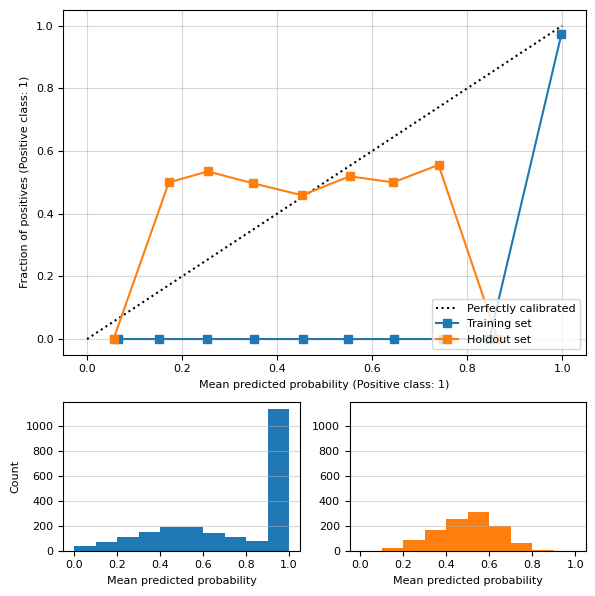

In [19]:
from sklearn.neighbors import KNeighborsClassifier
parameter_grid = {'n_neighbors': [3, 5, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1, 2, 3, 4]}

hyper_params_search(KNeighborsClassifier(), parameter_grid, 'sigmoid')
# Best found parameters: algorithm='kd_tree', n_neighbors=15, weights='distance'

Validator: No search parameters specified. Using default configuration.
Validator: Calibration improved the model from 0.1034 to 0.0993


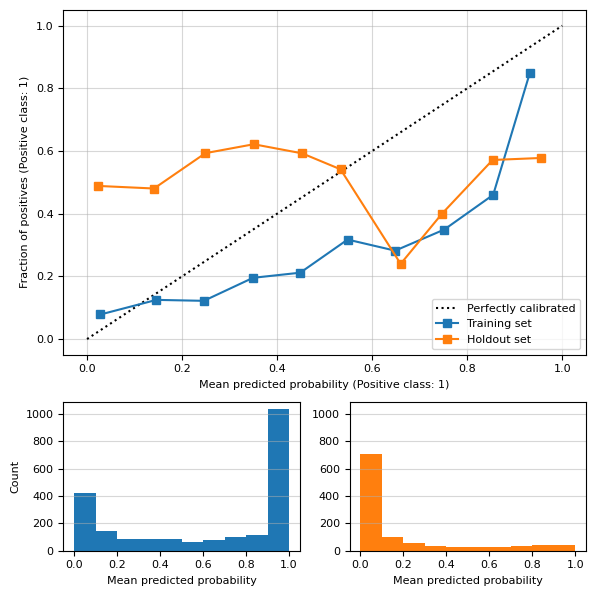

In [44]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

clf = make_pipeline(MinMaxScaler(), SVC(gamma='auto', probability=True, kernel='rbf', C=1000, class_weight='balanced'))
# parameter_grid = {'gamma': ['scale', 'auto'], 'class_weight': ['balanced', None], 'C': np.power(10, np.arange(-2, 2, dtype=float)), }

hyper_params_search(clf, parameter_grid=None, calibration_method='sigmoid')

Validator: Grid search for hyperparameters


Validator: Best Brier score -0.243143 using {'mlpclassifier__activation': 'tanh', 'mlpclassifier__alpha': 1e-05, 'mlpclassifier__hidden_layer_sizes': (100, 100), 'mlpclassifier__tol': 0.01}
Validator: Calibration improved the model from 0.0502 to 0.0491


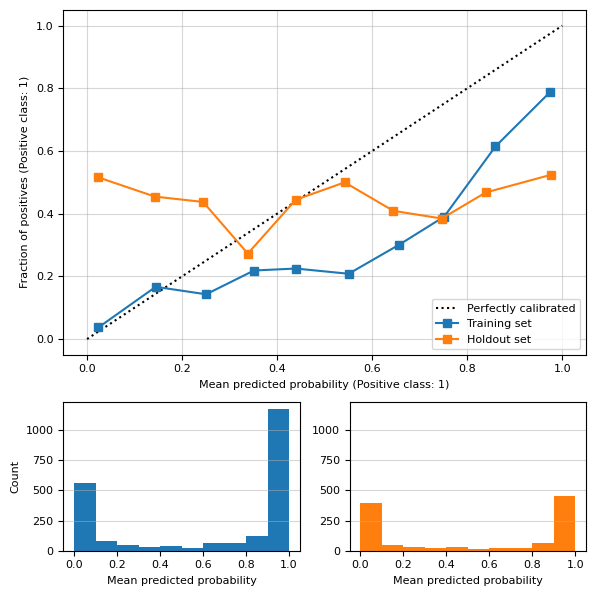

In [74]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

parameter_grid = {'mlpclassifier__alpha': np.power(10, np.arange(-5, 5, dtype=float)), 'mlpclassifier__tol': np.power(10, np.arange(-5, 1, dtype=float)),
                  'mlpclassifier__hidden_layer_sizes': [(100,), (50, 50), (25, 25, 25), (100, 100)], 'mlpclassifier__activation': ['identity', 'logistic', 'tanh', 'relu']}

clf = make_pipeline(StandardScaler(), MLPClassifier(early_stopping=True, max_iter=1000))

hyper_params_search(clf, parameter_grid, 'sigmoid')

Validator: Grid search for hyperparameters


/home/lautrup/sdg_env/lib/python3.10/site-packages/diffprivlib/models/forest.py:190: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/home/lautrup/sdg_env/lib/python3.10/site-packages/diffprivlib/models/forest.py:190: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/home/lautrup/sdg_env/lib/python3.10/site-packages/diffprivlib/models/forest.py:190: PrivacyLeakWarning: Bounds have not been spec

Validator: Best Brier score -0.249041 using {'randomforestclassifier__epsilon': 100.0, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 100}
Validator: Calibration did not improve the model. Using the original model.


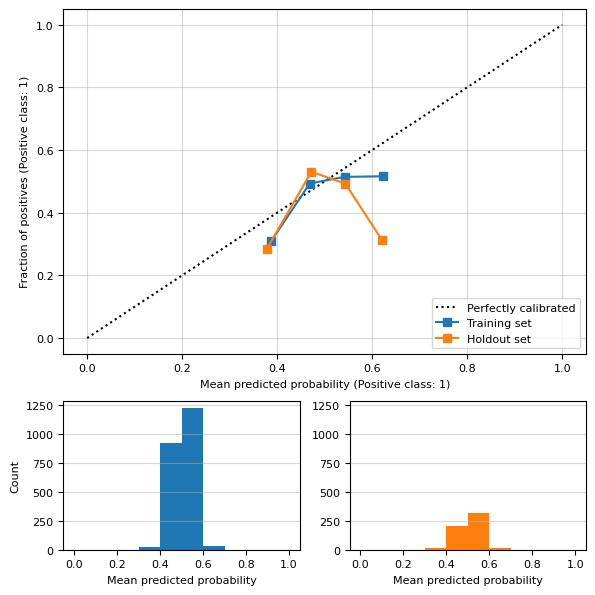

In [79]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from diffprivlib.models import RandomForestClassifier as DPRandomForestClassifier

parameter_grid = {'randomforestclassifier__n_estimators': [50, 100], 'randomforestclassifier__epsilon': np.logspace(-2, 2, 5),
                  'randomforestclassifier__max_depth': [5, 10, 15, None]}

clf = make_pipeline(StandardScaler(), DPRandomForestClassifier(classes=[[0],[1]]))

hyper_params_search(clf, parameter_grid, 'sigmoid')

# test correlated partitions using dummy data

In [3]:

import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs

X1, y = make_blobs(n_samples=250, centers=3, n_features=6, random_state=42)

X1 = pd.DataFrame(X1, columns=[f'feature_{i}' for i in range(X1.shape[1])])

# take X1 and multiply all features by specific factors
factors = [0.5, 1.5, 2, -6, -3, 8]
X2 = X1.copy()
X2 = X2.multiply(factors, axis=1)
X2.columns=[f'feature_{i+6}' for i in range(X2.shape[1])]

df = pd.concat((X1, X2), axis=1).reset_index(drop=True)

df_train = df.sample(frac=0.8, random_state=42)
df_test = df.drop(df_train.index).reset_index(drop=True)

df_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
142,-8.635405,5.807779,3.569805,5.957329,-10.201099,9.010495,-4.317702,8.711668,7.139611,-35.743975,30.603296,72.083964
6,-2.125132,8.981591,2.572437,1.884050,-8.184097,-6.210437,-1.062566,13.472387,5.144873,-11.304298,24.552290,-49.683496
97,-2.959263,9.637136,3.572258,1.830790,-6.759332,-6.365671,-1.479632,14.455704,7.144517,-10.984741,20.277995,-50.925366
60,-3.436128,8.954761,1.398611,0.948782,-7.132195,-8.127893,-1.718064,13.432141,2.797223,-5.692692,21.396586,-65.023142
112,8.243358,-6.600179,-7.354893,-8.485300,-4.554117,-0.827961,4.121679,-9.900269,-14.709786,50.911799,13.662351,-6.623689


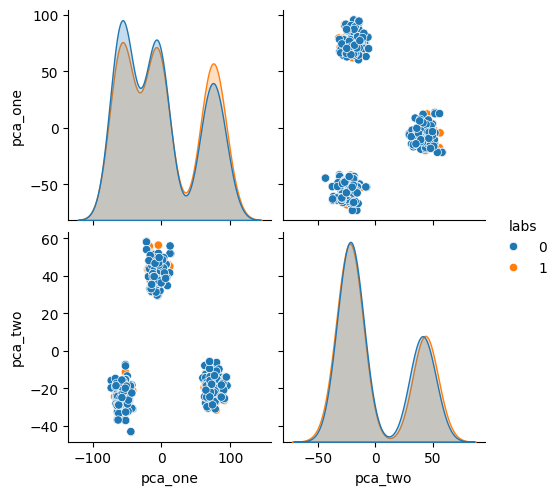

In [4]:
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA

from disjoint_generative_model.utils.joining_validator import JoiningValidator, _setup_training_data

data, labs  = _setup_training_data({'part1': df_train[X1.columns], 'part2': df_train[X2.columns]})
# data['labs'] = labs
# df = pd.concat(data, axis=0).reset_index(drop=True) 
# data

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)
data['pca_one'] = pca_result[:,0]
data['pca_two'] = pca_result[:,1]
data['labs'] = labs

sns.pairplot(data[['pca_one', 'pca_two', 'labs']], hue='labs')
plt.show()

AUROC: 0.8574999999999999
F1: 0.8533333333333334
Validator: No search parameters specified. Using default configuration.


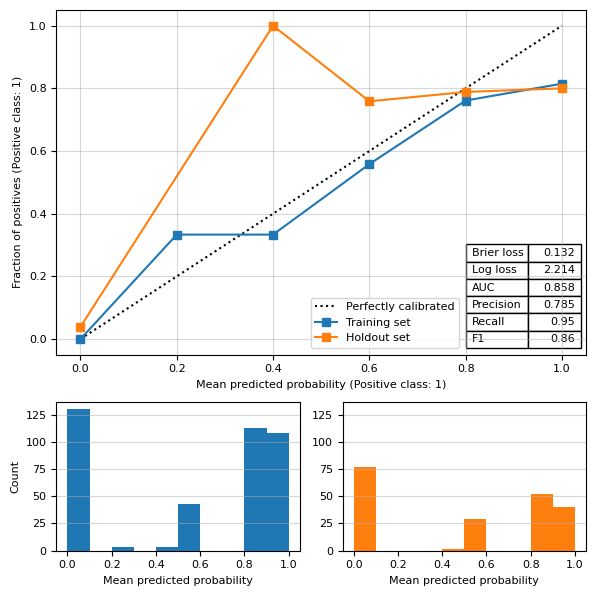

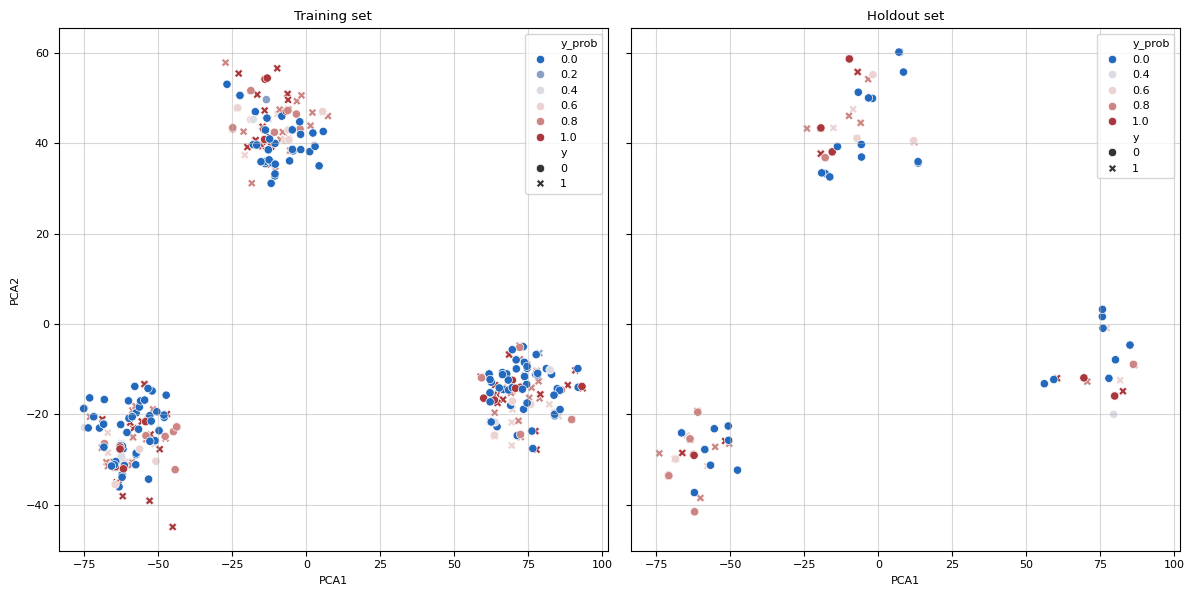

In [8]:

models = ['synthpop', 'mod2']

from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.generative_model_adapters import generate_synthetic_data
from disjoint_generative_model.utils.joining_validator import JoiningValidator, _setup_training_data
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator, Concatenating

def hyper_params_search(validator_model: object, parameter_grid: dict, calibration_method) -> None:

    JV = JoiningValidator(validator_model, model_parameter_grid = parameter_grid, calibration_method=calibration_method, verbose=True)
    JS = UsingJoiningValidator(JV)
    dgms = DisjointGenerativeModels(df_train, {models[0]: list(X1.columns), models[1]: list(X2.columns)}, joining_strategy=JS)
    dgms.num_samples = 20 # required or it will throw an error
    dgms._setup()
    
    # data, labs  = _setup_training_data({'part1': df_train[X1.columns], 'part2': df_train[X2.columns]})
    # dgms._strategy.join_validator.model.fit(data, labs)

    dgms._make_calibration_plot(df_test, save=False, stats=True)
    dgms._make_pred_pointplot(df_test, save=False)
    return dgms


from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score

clf = KNeighborsClassifier()
data, labs  = _setup_training_data({'part1': df_train[X1.columns], 'part2': df_train[X2.columns]})
clf.fit(data, labs)

data, labs  = _setup_training_data({'part1': df_test[X1.columns], 'part2': df_test[X2.columns]})
pred = clf.predict(data)
probs = clf.predict_proba(data)[:,1]

print(f"AUROC: {roc_auc_score(labs, probs)}")
print(f"F1: {f1_score(labs, pred)}")
# parameter_grid = {'n_neighbors': [3, 5, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1, 2, 3, 4]}

hyper_params_search(clf, None, None)

Find out more at https://www.synthpop.org.uk/


Synthetic data exported as csv file(s).
Information on synthetic data written to
  /home/lautrup/repositories/disjoint-synthetic-data-generation/synthesis_info_synthpop_temp_0_synthpop.txt 


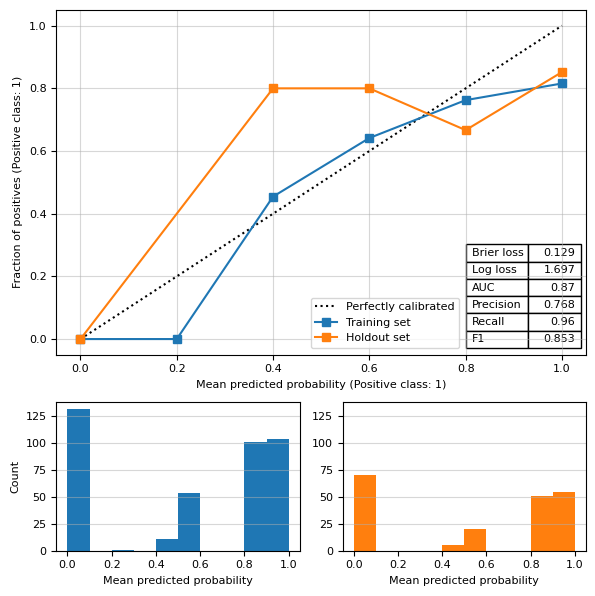

In [7]:
df_syn = generate_synthetic_data(df_train, 'synthpop')

dgms = DisjointGenerativeModels(df_train, {models[0]: list(X1.columns), models[1]: list(X2.columns)}, joining_strategy=UsingJoiningValidator(JoiningValidator(clf)), worker_id=0)
dgms._strategy.join_validator.pre_fit = True
dgms.num_samples = 20 # required or it will throw an error
dgms._setup()
dgms._make_calibration_plot(df_test, save=False, stats=True)

In [ ]:
from syntheval import SynthEval

from disjoint_generative_model.utils.generative_model_adapters import generate_synthetic_data

df_base = generate_synthetic_data(df_train, 'synthpop')

validateor_model = KNeighborsClassifier()
JV = UsingJoiningValidator(JoiningValidator(validateor_model, None, None))
dgms = DisjointGenerativeModels(df_train, ['synthpop', 'synthpop'], {'part1': list(X1.columns), 'part2': list(X2.columns)}, joining_strategy=JV)
df_val = dgms.fit_generate()

dgms = DisjointGenerativeModels(df_train, ['synthpop', 'synthpop'], {'part1': list(X1.columns), 'part2': list(X2.columns)}, joining_strategy=Concatenating())
df_con = dgms.fit_generate()

SE = SynthEval(df_train, df_test)

res, _ =SE.benchmark({'df_base': df_base, 'df_val': df_val, 'df_con': df_con}, rank_strategy='summation',
                      corr_diff={}, mi_diff={}, h_dist={}, eps_risk={})
res

Find out more at https://www.synthpop.org.uk/


Synthetic data exported as csv file(s).
Information on synthetic data written to
  /home/lautrup/repositories/disjoint-synthetic-data-generation/synthesis_info_synthpop_temp_0_synthpop.txt 
Validator: No search parameters specified. Using default configuration.


Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/


Synthetic data exported as csv file(s).
Information on synthetic data written to
  /home/lautrup/repositories/disjoint-synthetic-data-generation/synthesis_info_synthpop_temp_0_synthpop.txt 
Synthetic data exported as csv file(s).
Information on synthetic data written to
  /home/lautrup/repositories/disjoint-synthetic-data-generation/synthesis_info_synthpop_temp_1_synthpop.txt 
Threshold auto-set to: 1.0
Predicted good joins fraction: 0.105
Predicted good joins fraction: 0.07076350093109869
Predicted good joins fraction: 0.06012024048096192
Predicted good joins fraction: 0.05543710021321962
Predicted good joins fraction: 0.05417607223476298
Predicted good joins fraction: 0.028639618138424822
Predicted good joins fraction: 0.03194103194103194


Find out more at https://www.synthpop.org.uk/


Synthetic data exported as csv file(s).
Information on synthetic data written to
  /home/lautrup/repositories/disjoint-synthetic-data-generation/synthesis_info_synthpop_temp_1_synthpop.txt 


Find out more at https://www.synthpop.org.uk/


Synthetic data exported as csv file(s).
Information on synthetic data written to
  /home/lautrup/repositories/disjoint-synthetic-data-generation/synthesis_info_synthpop_temp_0_synthpop.txt 
Inferred categorical columns (unique threshold: 10):
[]


corr_mat_diff       mutual_inf_diff       avg_h_dist        \
                value error           value error      value error   
dataset                                                              
df_base      0.237306   NaN        1.297213   NaN        0.0   0.0   
df_val       0.897774   NaN        1.457044   NaN        0.0   0.0   
df_con       7.669287   NaN        1.399907   NaN        0.0   0.0   

        eps_identif_risk       priv_loss_eps            rank    u_rank  \
                   value error         value error                       
dataset                                                                  
df_base            0.695   NaN           0.5   NaN  2.000000  2.000000   
df_val             0.225   NaN         0.115   NaN  2.417592  0.911132   
df_con              0.05   NaN        -0.005   NaN  2.357486  0.357486   

          p_rank f_rank  
                         
dataset                  
df_base  0.00000    0.0  
df_val   1.50646    0.0  
df_con   2.00000    0.0